# РЕШЕНИЕ ЗАДАЧИ "ТРАССА: оптимальная траектория"

Требуется определить оптимальную траекторию при движении гоночной машины по трассе. 

Параметры управления: угол ориентации машины и её скорость
Параметры системы: координаты x и y
Выходной параметр: время движения по трассе (т.е. скорость должна быть как можно выше)
Критерий оптимизации: минимальное расстояние между предложенной трассой и расчетной трассой

Трасса определяется координатами x и y.

Описание задачи доступно по ссылке: https://drive.google.com/file/d/13k3FiNV7XmCUuIKt-00d8ua5r5QVYpBK/view?usp=sharing 

**Загрузка библиотек**


In [2]:
# УСТАНОВКА БИБЛИОТЕК

!pip install -q keras

In [ ]:
!pip install tensorflow

In [ ]:
# установка tf-Agent как в руководстве

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

In [ ]:
!pip install gym[all]
!pip install gym[box2d]
#!pip install gym atari-py
#!pip install Box2D
#!pip install box2d-kengz

In [3]:
# ИМПОРТ БИБЛИОТЕК

import os

#numpy & keras
import numpy as np 
import pandas as pd

# для визуализации данных
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# библиотека для обработки даты, времени
import datetime as dt
import time
from datetime import datetime, date, time, timedelta

#
import warnings
warnings.filterwarnings('ignore')

#tensorflow & keras
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [7]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

RuntimeError: ignored

In [13]:
print (np.__version__)

1.19.5


In [8]:
# из Notebook @author: Vadim Created on Thu Dec 16 15:50:11 2021
import argparse #argparse - это модуль для обработки аргументов командной строки
import pickle #pickle - Модуль pickle предоставляет функции и классы для сериализации и десериализации объектов

# 
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import tf_agents.trajectories.time_step as ts

from tf_agents.policies.policy_saver import PolicySaver

from tensorflow.python.client import device_lib

import re

# КЛАСС из ноутбука Notebook
@author: Vadim

In [9]:
class PPOTrainer:
    
    def __init__(self, ppo_agents, train_env, eval_env, size=(96, 96),
                 normalize=True, num_frames=1, num_channels=3,
                 use_tensorboard=True, add_to_video=True,
                 use_separate_agents=False, use_self_play=False,
                 num_agents=2, use_lstm=False, experiment_name="",
                 collect_steps_per_episode=1000, total_epochs=1000,
                 total_steps=1e6, eval_steps_per_episode=1000,
                 eval_interval=100, num_eval_episodes=5, epsilon=0.0,
                 save_interval=500, log_interval=1):

        self.train_env = train_env
        self.eval_env = eval_env  

        self.size = size
        self.H, self.W = self.size[0], self.size[1]  
        self.normalize = normalize
        self.num_frames = num_frames
        self.num_channels = num_channels

        self.use_separate_agents = use_separate_agents  
        self.use_self_play = use_self_play  
        self.use_lstm = use_lstm  
        self.num_agents = num_agents

        self.max_buffer_size = collect_steps_per_episode 
        self.collect_steps_per_episode = collect_steps_per_episode  
        self.epochs = total_epochs  
        self.total_steps = total_steps  
        self.global_step = 0  
        self.epsilon = epsilon 

        print("Total steps: {}".format(self.total_steps))

        # Create N different PPO agents
        if use_separate_agents and self.num_agents > 1:
            self.agents = ppo_agents  
            for agent in self.agents:
                agent.initialize()  
            self.actor_nets = [self.agents[i]._actor_net \
                               for i in range(self.num_agents)]
            self.value_nets = [self.agents[i]._value_net \
                               for i in range(self.num_agents)]
            self.eval_policies = [self.agents[i].policy \
                                  for i in range(self.num_agents)]
            self.collect_policies = [self.agents[i].collect_policy \
                                     for i in range(self.num_agents)]
            self.replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                self.agents[0].collect_data_spec,
                batch_size=self.train_env.batch_size,
                max_length=self.max_buffer_size)  # Create shared replay buffer

        else:
            self.agent = ppo_agents
            self.actor_net = self.agent._actor_net
            self.value_net = self.agent._value_net
            self.eval_policy = self.agent.policy
            self.collect_policy = self.agent.collect_policy
            self.replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                self.agent.collect_data_spec,
                batch_size=self.train_env.batch_size,
                max_length=self.max_buffer_size)

        if self.num_agents > 1:  
            self.observation_wrappers = \
                            [ObservationWrapper(size=self.size, normalize=self.normalize,
                                                num_channels=self.num_channels,
                                                num_frames=self.num_frames)
                             for i in range(self.num_agents)]

        else:  # Single observation wrapper for single car
            self.observation_wrapper = ObservationWrapper(size=self.size,
                                                          normalize=self.normalize,
                                                          num_channels=self.num_channels,
                                                          num_frames=self.num_frames)

        # Evaluation
        self.num_eval_episodes = num_eval_episodes  

        if self.use_separate_agents:
            self.eval_returns = [[] for i in range(self.num_agents)]

        else:
            self.eval_returns = []

        self.eval_interval = eval_interval  
        self.max_eval_episode_steps = eval_steps_per_episode  
        self.time_ext = datetime.now().strftime("%Y%m%d-%H%M")
        self.log_interval = log_interval
        self.video_train = []
        self.video_eval = []
        self.add_to_video = add_to_video
        self.FPS = 50  
        self.policy_save_dir = os.path.join(os.path.split(__file__)[0], "models",
                                            experiment_name.format(self.time_ext))
        self.save_interval = save_interval
        if not os.path.exists(self.policy_save_dir):
            print("Directory {} does not exist;"
                  " creating it now".format(self.policy_save_dir))
            os.makedirs(self.policy_save_dir, exist_ok=True)

        if self.use_separate_agents:
            self.train_savers = [PolicySaver(self.collect_policies[i],
                                             batch_size=None) for i in
                                 range(self.num_agents)]
            self.eval_savers = [PolicySaver(self.eval_policies[i],
                                            batch_size=None) for i in
                                range(self.num_agents)]

        else:
            self.train_saver = PolicySaver(self.collect_policy, batch_size=None)
            self.eval_saver = PolicySaver(self.eval_policy, batch_size=None)

        self.log_dir = os.path.join(os.path.split(__file__)[0], "logging",
                                    experiment_name.format(self.time_ext))
        self.tb_file_writer = tf.summary.create_file_writer(self.log_dir)
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir, exist_ok=True)
        self.use_tensorboard = use_tensorboard  
        self.size = size
        self.H, self.W = self.size
        self.stacked_channels = self.num_channels * self.num_frames
        if self.use_tensorboard:
            self.tb_gif_train = np.zeros((self.collect_steps_per_episode,
                                         self.num_agents, self.H, self.W,
                                          self.stacked_channels))
            self.tb_gif_eval = np.zeros((self.max_eval_episode_steps,
                                        self.num_agents, self.H, self.W,
                                         self.stacked_channels))
        # Devices
        local_device_protos = device_lib.list_local_devices()
        num_gpus = len([x.name for x in local_device_protos if
                        x.device_type == 'GPU'])
        self.use_gpu = num_gpus > 0

    def is_last(self, mode='train'):
        
        if mode == 'train':
            step_types = self.train_env.current_time_step().step_type.numpy()
        elif mode == 'eval':
            step_types = self.eval_env.current_time_step().step_type.numpy()


        is_last = bool(min(np.count_nonzero(step_types == 2), 1))
        return is_last

    def get_agent_timesteps(self, time_step, step=0,
                            only_ego_car=False, ego_car_index=0, max_steps=1000):
        
        discount = time_step.discount
        if len(discount.numpy().shape) > 1 or discount.numpy().shape[0] > 1:
            discount = discount[0]
        discount = tf.convert_to_tensor(discount, dtype=tf.float32,
                                        name='discount')

        
        if step == 0:  
            step_type = 0
        elif step == max_steps-1:  
            step_type = 2
        else:  # Middle time step
            step_type = 1
        step_type = tf.convert_to_tensor([step_type], dtype=tf.int32,
                                         name='step_type')

        # Extract rewards for all agents
        try:
            R = [tf.convert_to_tensor(time_step.reward[:, car_id],
                                      dtype=tf.float32, name='reward') \
                 for car_id in range(self.num_agents)]
        except:
            R = [tf.convert_to_tensor(time_step.reward,
                                      dtype=tf.float32, name='reward') \
                 for _ in range(self.num_agents)]

        if only_ego_car:
            processed_observation = \
                self._process_observations(time_step, only_ego_car=only_ego_car,
                                           ego_car_index=ego_car_index)
            return ts.TimeStep(step_type, R[ego_car_index], discount,
                                   tf.convert_to_tensor(processed_observation,
                                   dtype=tf.float32, name='observations'))

        else:
            processed_observations = \
                self._process_observations(time_step, only_ego_car=only_ego_car,
                                           ego_car_index=ego_car_index)
            return [ts.TimeStep(step_type, R[car_id], discount,
                    tf.convert_to_tensor(processed_observations[car_id],
                                         dtype=tf.float32, name='observations'))
                    for car_id in range(self.num_agents)]

    def _process_observations(self, time_step, only_ego_car=False,
                              ego_car_index=0):

        if only_ego_car:
            input_observation = time_step.observation[:, ego_car_index]

            if self.num_agents > 1:  
                wrapper = self.observation_wrappers[ego_car_index]
            else:
                wrapper = self.observation_wrapper

            processed_observation = wrapper.get_obs_and_step(input_observation)

            return tf.convert_to_tensor(processed_observation, dtype=tf.float32,
                                        name='observations')

        else:
            input_observations = [time_step.observation[:, car_id] for
                                  car_id in range(self.num_agents)]
            if self.num_agents > 1:  
                processed_observations = \
                    [wrapper.get_obs_and_step(input_observation)
                     for wrapper, input_observation in
                     zip(self.observation_wrappers, input_observations)]

            else:  # Single car
                processed_observations = \
                    [self.observation_wrapper.get_obs_and_step(
                        input_observations[0])]

            return [tf.convert_to_tensor(processed_observations[car_id],
                                    dtype=tf.float32, name='observations')
                    for car_id in range(self.num_agents)]

    def collect_step(self, step=0, ego_car_index=0, use_greedy=False,
                     add_to_video=False):
        
        time_step = self.train_env.current_time_step()

        actions = []

        agent_timesteps = self.get_agent_timesteps(time_step, step=step,
                                                   only_ego_car=False,
                                                   max_steps=self.max_eval_episode_steps-1)

        if self.use_separate_agents:
            ego_agent_policy = self.collect_policies[ego_car_index]
        else:
            ego_agent_policy = self.collect_policy


        NUM_AGENTS = 1 
        for car_id in range(NUM_AGENTS):

            if car_id == ego_car_index:
                ego_agent_ts = agent_timesteps[car_id]
                ego_action_step = ego_agent_policy.action(ego_agent_ts)
                if use_greedy:
                    actions.append(ego_action_step.info['loc'])  
                else:
                    actions.append(ego_action_step.action)  

                if self.add_to_video:
                    rendered_state = time_step.observation[:, car_id].numpy()
                    if self.stacked_channels > 3: 
                        rendered_state = rendered_state[:, :, :, :3] 
                    self.video_train.append(rendered_state)

            elif self.use_separate_agents:
                other_agent_ts = agent_timesteps[car_id]
                action_step = self.eval_policies[car_id].action(other_agent_ts)
                actions.append(action_step.action)

            elif self.use_self_play:
                other_agent_ts = agent_timesteps[car_id]
                action_step = self.eval_policy.action(other_agent_ts)
                actions.append(action_step.action)

        if self.use_tensorboard:
            processed_observations = self._process_observations(time_step,
                                                               only_ego_car=False)
            self.tb_gif_train[step] = tf.convert_to_tensor(processed_observations)

        action_tensor = tf.convert_to_tensor([tf.stack(tuple(actions), axis=1)])

        next_time_step = self.train_env.step(action_tensor)
        ego_agent_next_ts = self.get_agent_timesteps(next_time_step, step=step+1,
                                                     ego_car_index=ego_car_index,
                                                     only_ego_car=True,
                                                     max_steps=self.collect_steps_per_episode-1)

        traj = trajectory.from_transition(ego_agent_ts, ego_action_step,
                                          ego_agent_next_ts)
        self.replay_buffer.add_batch(traj)

        if add_to_video:
            rendered_state = time_step.observation[:, ego_car_index].numpy()
            if self.num_frames > 1:  
                rendered_state = rendered_state[:, :, :, :3]  # First frame
            self.video_train.append(rendered_state)

        return float(ego_agent_ts.reward)

    def collect_episode(self, epoch=0, ego_car_index=0, add_to_video=False):
        
        episode_reward = 0  
        step = 0  

        self.train_env.reset()

        use_greedy = float(np.random.binomial(n=1, p=self.epsilon))

        while step < self.collect_steps_per_episode and \
                not self.is_last(mode='train'):
            episode_reward += self.collect_step(add_to_video=add_to_video,
                                                step=step, use_greedy=use_greedy,
                                                ego_car_index=ego_car_index)
            step += 1

        self.global_step += step

        if self.use_tensorboard:
            with self.tb_file_writer.as_default():
                tf.summary.scalar("Average Training Reward", float(episode_reward),
                                  step=self.global_step)
                frames = self.tb_gif_train
                video_summary("train/grid", frames, fps=self.FPS,
                              step=self.global_step, channels=self.num_channels)

            self.tb_gif_train = np.zeros((self.collect_steps_per_episode,
                                         self.num_agents, self.H, self.W,
                                          self.stacked_channels))

    def compute_average_reward(self, ego_car_index=0):
        
        total_return = 0.0  

        for e in range(self.num_eval_episodes):
            time_step = self.eval_env.reset()

            # Initialize step counter and episode_return
            i = 0
            episode_return = 0.0
            while i < self.max_eval_episode_steps and \
                    not self.is_last(mode='eval'):
                actions = []

                agent_timesteps = self.get_agent_timesteps(time_step, step=i)
                for car_id in range(self.num_agents):

                    if car_id == ego_car_index:  
                        ego_agent_ts = agent_timesteps[car_id]
                        rendered_state = ego_agent_ts.observation.numpy()
                        if self.num_frames > 1:  
                            rendered_state = rendered_state[..., :3] 
                        self.video_eval.append(rendered_state)

                        if self.use_separate_agents:  
                            ego_action_step = self.eval_policies[car_id].action(ego_agent_ts)
                            actions.append(ego_action_step.action)   

                        elif self.use_self_play:  
                            ego_action_step = self.eval_policy.action(ego_agent_ts)
                            actions.append(ego_action_step.action) 

                    elif self.use_separate_agents:
                        other_agent_ts = agent_timesteps[car_id]
                        action_step = self.eval_policies[car_id].action(other_agent_ts)
                        actions.append(action_step.action)

                   
                    elif self.use_self_play:
                        other_agent_ts = agent_timesteps[car_id]
                        action_step = self.eval_policy.action(other_agent_ts)
                        actions.append(action_step.action)

                action_tensor = tf.convert_to_tensor([tf.stack(tuple(actions),
                                                               axis=1)])

                time_step = self.eval_env.step(action_tensor)

                if self.use_tensorboard:
                    processed_observations = self._process_observations(time_step,
                                                                        only_ego_car=False)
                    self.tb_gif_eval[i] = tf.convert_to_tensor(processed_observations)

                episode_return += ego_agent_ts.reward  
                if i % 250 == 0:
                    action = ego_action_step.action.numpy()
                    print("Action: {}, "
                          "Reward: {}".format(action, episode_return))
                i += 1

            print("Steps in episode: {}".format(i))
            total_return += episode_return
        avg_return = total_return / self.num_eval_episodes

        if self.use_tensorboard:
            with self.tb_file_writer.as_default():
                video_summary("eval/grid".format(car_id), self.tb_gif_eval,
                              fps=self.FPS, step=self.global_step,
                              channels=self.num_channels)

            self.tb_gif_eval = np.zeros((self.max_eval_episode_steps,
                                        self.num_agents, self.H, self.W,
                                         self.stacked_channels))

        print("Average return: {}".format(avg_return))


        if self.use_separate_agents:  
            self.eval_returns[ego_car_index].append(avg_return)
        else:  
            self.eval_returns.append(avg_return)

        return avg_return

    def collect_step_lstm(self, step=0, ego_car_index=0, add_to_video=False,
                          policy_states=None):
        
        time_step = self.train_env.current_time_step()

        # Create empty list of actions and next policy states
        actions = []
        next_policy_states = {}

        agent_timesteps = self.get_agent_timesteps(time_step, step=step,
                                                   only_ego_car=False)

        if self.use_separate_agents:
            ego_agent_policy = self.collect_policies[ego_car_index]
        else:
            ego_agent_policy = self.collect_policy

        for car_id in range(self.num_agents):
            if car_id == ego_car_index:
                ego_agent_ts = agent_timesteps[car_id]
                if self.use_separate_agents:
                    ego_policy_step = ego_agent_policy.action(
                        ego_agent_ts, policy_states[car_id])
                else:
                    ego_policy_step = self.collect_policy.action(ego_agent_ts,
                                                                 policy_states[car_id])
                if use_greedy:
                    actions.append(ego_action_step.info['loc']) 
                else:
                    actions.append(ego_action_step.action)  
                policy_state = ego_policy_step.state

                if self.add_to_video:
                    rendered_state = time_step.observation[:, car_id].numpy()
                    if self.num_frames > 1:  
                        rendered_state = rendered_state[..., :3] 
                    self.video_train.append(rendered_state)

            elif self.use_separate_agents:
                other_agent_ts = agent_timesteps[car_id]
                policy_step = self.eval_policies[car_id].action(other_agent_ts, policy_states[car_id])
                policy_state = policy_step.state
                actions.append(policy_step.action)  

            elif self.use_self_play:
                other_agent_ts = agent_timesteps[car_id]
                policy_step = self.eval_policy.action(other_agent_ts, policy_states[car_id])
                policy_state = policy_step.state
                actions.append(policy_step.action)

            next_policy_states[car_id] = policy_state  

        if self.use_tensorboard:
            processed_observations = self._process_observations(time_step,
                                                                only_ego_car=False)
            self.tb_gif_train[step] = tf.convert_to_tensor(processed_observations)

        action_tensor = tf.convert_to_tensor([tf.stack(tuple(actions), axis=1)])

        next_time_step = self.train_env.step(action_tensor)
        ego_agent_next_ts = self.get_agent_timesteps(next_time_step,
                                                     step=step + 1,
                                                     ego_car_index=ego_car_index,
                                                     only_ego_car=True)

        traj = trajectory.from_transition(ego_agent_ts, ego_policy_step,
                                          ego_agent_next_ts)
        self.replay_buffer.add_batch(traj)

        if add_to_video:
            rendered_state = time_step.observation[:, ego_car_index].numpy()
            if self.num_frames > 1:
                rendered_state = rendered_state[:, :, :, 3]  
            self.video_train.append(rendered_state)

        return next_policy_states, float(ego_agent_ts.reward)

    def reset_policy_states(self, ego_car_index=0, mode='train'):
        
        if mode == 'train':
            if self.use_separate_agents:
                policy_states = {car_id: self.eval_policies[car_id].get_initial_state(
                    self.train_env.batch_size) for car_id in range(self.num_agents)}
                policy_states[ego_car_index] = self.collect_policies[
                    ego_car_index].get_initial_state(self.train_env.batch_size)
            else:
                policy_states = {car_id: self.eval_policy.get_initial_state(self.train_env.batch_size)
                                 for car_id in range(self.num_agents)}
                policy_states[ego_car_index] = self.collect_policy.get_initial_state(
                    self.train_env.batch_size)

        elif mode == 'eval':
            if self.use_separate_agents:
                policy_states = {
                    car_id: self.eval_policies[car_id].get_initial_state(
                        self.eval_env.batch_size) for car_id in
                    range(self.num_agents)}
            else:
                policy_states = {car_id: self.eval_policy.get_initial_state(
                    self.eval_env.batch_size) for car_id in
                    range(self.num_agents)}

        return policy_states

    def collect_episode_lstm(self, epoch=0, ego_car_index=0, add_to_video=False):
        
        policy_states = self.reset_policy_states(ego_car_index=ego_car_index)

        episode_reward = 0  
        step = 0

        self.train_env.reset()

        use_greedy = float(np.random.binomial(n=1, p=self.epsilon))

        while step < self.collect_steps_per_episode and \
                not self.is_last(mode='train'):
            if step % 1000 == 0:
                print("Step number: {}".format(step))
            policy_states, ego_reward = self.collect_step_lstm(add_to_video=add_to_video,
                                                               step=step, use_greedy=use_greedy,
                                                               ego_car_index=ego_car_index,
                                                               policy_states=policy_states)
            episode_reward += ego_reward
            step += 1

        self.global_step += step

        if self.use_tensorboard:
            with self.tb_file_writer.as_default():
                tf.summary.scalar("Average Training Reward", float(episode_reward),
                                  step=self.global_step)
                frames = self.tb_gif_train
                video_summary("train/grid", frames, fps=self.FPS,
                              step=self.global_step,
                              channels=self.num_channels)

            self.tb_gif_train = np.zeros((self.collect_steps_per_episode,
                                          self.num_agents, self.H, self.W,
                                          self.stacked_channels))

    def compute_average_reward_lstm(self, ego_car_index=0):
        
        total_return = 0.0

        for _ in range(self.num_eval_episodes):
            time_step = self.eval_env.reset()

            i = 0
            episode_return = 0.0

            policy_states = self.reset_policy_states(ego_car_index=ego_car_index,
                                                     mode='eval')

            while i < self.max_eval_episode_steps and \
                    not self.is_last(mode='eval'):

                actions = []

                agent_timesteps = self.get_agent_timesteps(time_step, step=i)
                NUM_AGENTS = 1
                for car_id in range(NUM_AGENTS):

                    if car_id == ego_car_index:
                        ego_agent_ts = agent_timesteps[car_id]
                        rendered_state = ego_agent_ts.observation.numpy()
                        if self.num_frames > 1:
                            rendered_state = rendered_state[..., :3]  
                        self.video_eval.append(rendered_state)

                        if self.use_separate_agents:  
                            ego_policy_step = self.eval_policies[car_id].action(ego_agent_ts,
                                                                                policy_states[car_id])
                            actions.append(ego_policy_step.action)  

                        elif self.use_self_play:  
                            ego_policy_step = self.eval_policy.action(ego_agent_ts,
                                                                      policy_states[car_id])
                            actions.append(ego_policy_step.action)  

                        policy_state = ego_policy_step.state

                    elif self.use_separate_agents:
                        other_agent_ts = agent_timesteps[car_id]
                        policy_step = self.eval_policies[car_id].action(other_agent_ts,
                                                                        policy_states[car_id])
                        actions.append(policy_step.action)
                        policy_state = policy_step.state

                    elif self.use_self_play:
                        other_agent_ts = agent_timesteps[car_id]
                        policy_step = self.eval_policy.action(other_agent_ts,
                                                              policy_states[car_id])
                        actions.append(policy_step.action)
                        policy_state = policy_step.state

                    policy_states[car_id] = policy_state

                action_tensor = tf.convert_to_tensor([tf.stack(tuple(actions), axis=1)])

                time_step = self.eval_env.step(action_tensor)

                if self.use_tensorboard:
                    processed_observations = self._process_observations(time_step,
                                                                        only_ego_car=False)
                    self.tb_gif_eval[i] = tf.convert_to_tensor(processed_observations)

                episode_return += ego_agent_ts.reward 
                if i % 250 == 0:
                    action = ego_policy_step.action.numpy()
                    print("Action: {}, "
                          "Reward: {}".format(action, episode_return))
                    print("POLICY STATES: {}".format(
                        [np.sum(policy_states[i]) for i
                         in range(self.num_agents)]))
                i += 1
            print("Steps in episode: {}".format(i))
            total_return += episode_return
        avg_return = total_return / self.num_eval_episodes

        
        print("Average return: {}".format(avg_return))

        if self.use_separate_agents:  
            self.eval_returns[ego_car_index].append(avg_return)
        else: 
            self.eval_returns.append(avg_return)

        return avg_return

    def train_agent(self):
        
        eval_epochs = []

        # Optimize by wrapping some of the code in a graph using TF function.
        if self.use_separate_agents:
            for car_id in range(self.num_agents):
                self.agents[car_id].train = common.function(self.agents[car_id].train)
                self.agents[car_id].train_step_counter.assign(0)
        else:
            self.agent.train = common.function(self.agent.train)

        # Compute pre-training returns
        if self.use_lstm:
            avg_return = self.compute_average_reward_lstm(ego_car_index=0)

        else:
            avg_return = self.compute_average_reward(ego_car_index=0)

        # Log average training return to tensorboard
        if self.use_tensorboard:
            with self.tb_file_writer.as_default():
                tf.summary.scalar("Average Eval Reward", float(avg_return),
                                  step=self.global_step)

        print("DONE WITH PRELIMINARY EVALUATION...")

        # Append for output plot, create video, and empty eval video array
        eval_epochs.append(0)
        self.create_video(mode='eval', ext=0)
        self.video_eval = []  # Empty to create a new eval video
        returns = [avg_return]

        # Reset the environment time step and global and episode step counters
#        time_step = self.train_env.reset()
        step = 0
        i = 0

        for i in range(self.epochs):

            if self.global_step >= self.total_steps:
                print("Reached the end of training with {} training steps".format(self.global_step))
                break

            ego_car_index = i % self.num_agents
            print("Training epoch: {}".format(i))

            print("Collecting episode for car with ID {}".format(ego_car_index))

            self.video_train = []

            if self.use_lstm:
                self.collect_episode_lstm(epoch=i, ego_car_index=ego_car_index)
                print("LSTM")

            else:
                self.collect_episode(epoch=i, ego_car_index=ego_car_index)
                print("No LSTM")

            if i % 100 == 0 and self.add_to_video:
                self.create_video(mode='train', ext=i)  
            print("Collected Episode")

            if self.use_gpu:
                device = '/gpu:0'
            else:
                device = '/cpu:0'

            with tf.device(device):

                trajectories = self.replay_buffer.gather_all()

                if self.use_separate_agents:

                    train_loss = self.agents[ego_car_index].train(experience=trajectories)

                    if self.use_tensorboard:
                        with self.tb_file_writer.as_default():
                            tf.summary.scalar("Training Loss Agent {}".format(ego_car_index),
                                              float(train_loss.loss),
                                              step=self.global_step // self.num_agents)

                    step = self.agents[ego_car_index].train_step_counter.numpy()


                else:
                    train_loss = self.agent.train(experience=trajectories)

                    if self.use_tensorboard:
                        with self.tb_file_writer.as_default():
                            tf.summary.scalar("Training Loss",
                                              float(train_loss.loss), step=self.global_step)

            with tf.device('/cpu:0'):

                if self.global_step % self.log_interval == 0:
                    print('step = {0}: loss = {1}'.format(self.global_step,
                                                          train_loss.loss))

                if i % self.eval_interval == 0:

                    if self.use_lstm:
                        avg_return = self.compute_average_reward_lstm(ego_car_index=ego_car_index)
                    else:
                        avg_return = self.compute_average_reward(ego_car_index=ego_car_index)

                    if self.use_tensorboard:
                        with self.tb_file_writer.as_default():
                            tf.summary.scalar("Average Eval Reward",
                                              float(avg_return),
                                              step=self.global_step)
                    eval_epochs.append(i + 1)
                    print(
                        'epoch = {0}: Average Return = {1}'.format(step, avg_return))
                    returns.append(avg_return)
                    if self.add_to_video:
                        self.create_video(mode='eval', ext=i)
                    self.video_eval = []  

                if i % self.save_interval == 0 and i != 0:
                    self.save_policies(epochs_done=i)
                    print("Epochs: {}".format(i))

                self.replay_buffer.clear()

        if self.use_separate_agents:
            return self.agents
        else:
            return self.agent

    def create_video(self, mode='eval', ext=0, ego_car_index=0):
        
        if mode == 'eval':  
            video = self.video_eval
        elif mode == 'train':  
            video = self.video_train

        if len(video) == 0:
            raise AssertionError("Video is empty.")
        print("Number of frames in video: {}".format(len(video)))
        obs_size = video[0].shape
        width = np.uint(obs_size[-3])
        height = np.uint(obs_size[-2])
        channels = np.uint(obs_size[-1])
        print("HEIGHT IS: {}, WIDTH IS: {}, CHANNELS IS: {}".format(width, height, channels))

        fourcc = cv.VideoWriter_fourcc(*'XVID')
        out_file = os.path.join(self.log_dir,
                                "trajectories_{}_epoch_{}_agent_{}"
                                ".avi".format(mode, ext, ego_car_index))
        out = cv.VideoWriter(out_file, fourcc, self.FPS, (width, height))

        for i in range(len(video)):
            img_rgb = cv.cvtColor(np.uint8(255 * video[i][0]),
                                  cv.COLOR_BGR2RGB)  # Save as RGB image
            out.write(img_rgb)
        out.release()

    def plot_eval(self):
    
        if self.use_separate_agents:  
            for car_id in range(self.num_agents):
                xs = [i * self.eval_interval for
                      i in range(len(self.eval_returns[car_id]))]
                plt.plot(xs, self.eval_returns[car_id])
                plt.xlabel("Training epochs")
                plt.ylabel("Average Return")
                plt.title("Average Returns as a Function "
                          "of Training (Agent {})".format(car_id))
                save_path = os.path.join(self.policy_save_dir,
                                         "eval_returns_agent_{}"
                                         ".png".format(car_id))
                plt.savefig(save_path)
                print("Created plot of returns for agent {}...".format(car_id))

        else:
            xs = [i * self.eval_interval for i in range(len(self.eval_returns))]
            plt.plot(xs, self.eval_returns)
            plt.xlabel("Training epochs")
            plt.ylabel("Average Return")
            plt.title("Average Returns as a Function of Training")
            save_path = os.path.join(self.policy_save_dir, "eval_returns.png")
            plt.savefig(save_path)
            print("CREATED PLOT OF RETURNS")


    def save_policies(self, epochs_done=0, is_final=False):
       
        if is_final:
            epochs_done = "FINAL"

        if self.use_separate_agents:

            for i, train_saver in enumerate(self.train_savers):
                if custom_path is None:
                    train_save_dir = os.path.join(self.policy_save_dir, "train",
                                                 "epochs_{}".format(epochs_done),
                                                 "agent_{}".format(i))
                else:
                    train_save_dir = os.path.join(self.policy_save_dir, "train",
                                                  "epochs_{}".format(
                                                      custom_path),
                                                  "agent_{}".format(i))
                if not os.path.exists(train_save_dir):
                    os.makedirs(train_save_dir, exist_ok=True)
                train_saver.save(train_save_dir)

            print("Training policies saved...")

            for i, eval_saver in enumerate(self.eval_savers):
                eval_save_dir = os.path.join(self.policy_save_dir, "eval",
                                             "epochs_{}".format(epochs_done),
                                             "agent_{}".format(i))
                if not os.path.exists(eval_save_dir):
                    os.makedirs(eval_save_dir, exist_ok=True)
                eval_saver.save(eval_save_dir)

            print("Eval policies saved...")

        else:
            train_save_dir = os.path.join(self.policy_save_dir, "train",
                                          "epochs_{}".format(epochs_done))
            if not os.path.exists(train_save_dir):
                os.makedirs(train_save_dir, exist_ok=True)
            self.train_saver.save(train_save_dir)

            print("Training policy saved...")

            # Save eval policy
            eval_save_dir = os.path.join(self.policy_save_dir, "eval",
                                         "epochs_{}".format(epochs_done))
            if not os.path.exists(eval_save_dir):
                os.makedirs(eval_save_dir, exist_ok=True)
            self.eval_saver.save(eval_save_dir)

            print("Eval policy saved...")

        agent_params = {'normalize_obs': self.train_env.normalize,
                        'use_lstm': self.use_lstm,
                        'frame_stack': self.use_multiple_frames,
                        'num_frame_stack': self.env.num_frame_stack,
                        'obs_size': self.size}

        params_path = os.path.join(self.policy_save_dir, "parameters.pkl")
        with open(params_path, "w") as pkl_file:
            pickle.dump(agent_params, pkl_file)
        pkl_file.close()

    def load_saved_policies(self, eval_model_path=None, train_model_path=None):
    
        if eval_model_path is not None:
            self.eval_policy = tf.saved_model.load(eval_model_path)
            print("Loading evaluation policy from: {}".format(eval_model_path))

        if train_model_path is not None:
            self.collect_policy = tf.saved_model.load(train_model_path)
            print("Loading training policy from: {}".format(train_model_path))


def parse_args():
    """Argument-parsing function for running this code."""

    parser = argparse.ArgumentParser()

    parser.add_argument("-n", "--num_agents", default=2, type=int,
                        help="Number of cars in the environment.")
    parser.add_argument("-size", "--size", required=False,
                        default="96",
                        help="The width and height of the observation window.")
    parser.add_argument("-direction", "--direction", type=str, default='CCW',
                        help="Direction in which agents traverse the track.")
    parser.add_argument("-random_direction", "--use_random_direction",
                        required=False, action='store_true',
                        help="Whether agents are trained/evaluated on "
                             "both CW and CCW trajectories across the track.")
    parser.add_argument("-backwards_flag", "--backwards_flag", required=False,
                        action="store_true",
                        help="Whether to render a backwards flag indicator when "
                             "an agent drives on the track backwards.")
    parser.add_argument("-h_ratio", "--h_ratio", type=float, default=0.25,
                        help="Default height location fraction for where car"
                             "is located in observation upon rendering.")
    parser.add_argument("-ego_color", "--use_ego_color", required=False,
                        action="store_true", default="Whether to render each "
                                                     "ego car in the same color.")

    parser.add_argument("-self_play", "--use_self_play",
                        required=False, action="store_true",
                        help="Flag for whether to use a single master PPO agent.")
    parser.add_argument("-n_agents", "--use_separate_agents",
                        required=False, action="store_true",
                        help="Flag for whether to use a N PPO agents.")

    parser.add_argument("-epochs", "--total_epochs", default=1000, type=int,
                        help="Number of epochs to train agent over.")
    parser.add_argument("-steps", "--total_steps", type=int, default=10e6,
                        help="Total number of training steps to take.")
    parser.add_argument("-collect_episode_steps", "--collect_steps_per_episode",
                        default=1000, type=int,
                        help="Number of steps to take per collection episode.")
    parser.add_argument("-eval_episode_steps", "--eval_steps_per_episode",
                        default=1000, type=int,
                        help="Number of steps to take per evaluation episode.")
    parser.add_argument("-eval_interval", "--eval_interval", default=10,
                        type=int,
                        help="Evaluate every time epoch % eval_interval = 0.")
    parser.add_argument("-eval_episodes", "--num_eval_episodes", default=5,
                        type=int,
                        help="Evaluate over eval_episodes evaluation episodes.")
    parser.add_argument("-lr", "--learning_rate", default=5e-8, type=float,
                        help="Learning rate for PPO agent(s).")
    parser.add_argument("-lstm", "--use_lstm", required=False, action="store_true",
                        help="Flag for whether to use LSTMs on actor and critic"
                             "networks of the PPO agent.")
    parser.add_argument("-eps", "--epsilon", type=float, default=0.0,
                        help="Probability of training on the greedy policy for a"
                             "given episode")

    parser.add_argument("-si", "--save_interval", default=10, type=int,
                        help="Save policies every time epoch % eval_interval = 0.")
    parser.add_argument("-li", "--log_interval", default=1, type=int,
                        help="Log results every time epoch % eval_interval = 0.")
    parser.add_argument("-tb", "--use_tensorboard", required=False,
                        action="store_true", help="Log with tensorboard as well.")
    parser.add_argument("-add_to_video", "--add_to_video", required=False,
                        action="store_true",
                        help="Whether to save trajectories as videos.")

    parser.add_argument("-exp_name", "--experiment_name", type=str,
                        default="experiment_{}", required=False,
                        help="Name of experiment (for logging).")

    args = parser.parse_args()

    print("Your selected training parameters: \n {}".format(vars(args)))
    return args


def main():
    main()

# КОД из ноутбука Optima_1
@author: Vadim

In [ ]:
!pip install control

Summary statistics:
* Cost function calls: 693
* System simulations: 693
Время t:
 [ 0.          1.34888889  2.69777778  4.04666667  5.39555556  6.74444444
  8.09333333  9.44222222 10.79111111 12.14      ]
Функция g(х,y):
 [[ 0.00000000e+00  1.47576270e+01  2.95097620e+01  4.42557123e+01
   5.90032412e+01  7.37580046e+01  8.85145050e+01  1.03271324e+02
   1.18020796e+02  1.32740718e+02]
 [-2.00000000e+00 -1.83716668e+00 -1.33920381e+00 -7.21619358e-01
  -1.59852293e-01  1.56249815e-01  3.56077799e-01  5.01088824e-01
   9.67984150e-01  2.00346561e+00]
 [ 0.00000000e+00  2.34946105e-02  4.03465583e-02  4.23755271e-02
   2.98501976e-02  1.63593982e-02  9.33213174e-03  1.65362469e-02
   4.90186602e-02  9.29125539e-02]]
Функция u(скорость, угол):
 [[ 1.09413755e+01  1.09419106e+01  1.09414488e+01  1.09413525e+01
   1.09409246e+01  1.09407626e+01  1.09405797e+01  1.09405225e+01
   1.09404652e+01  1.09404855e+01]
 [ 3.80443368e-03  5.81805311e-03  8.76031705e-04  1.54404102e-05
  -5.11460662e

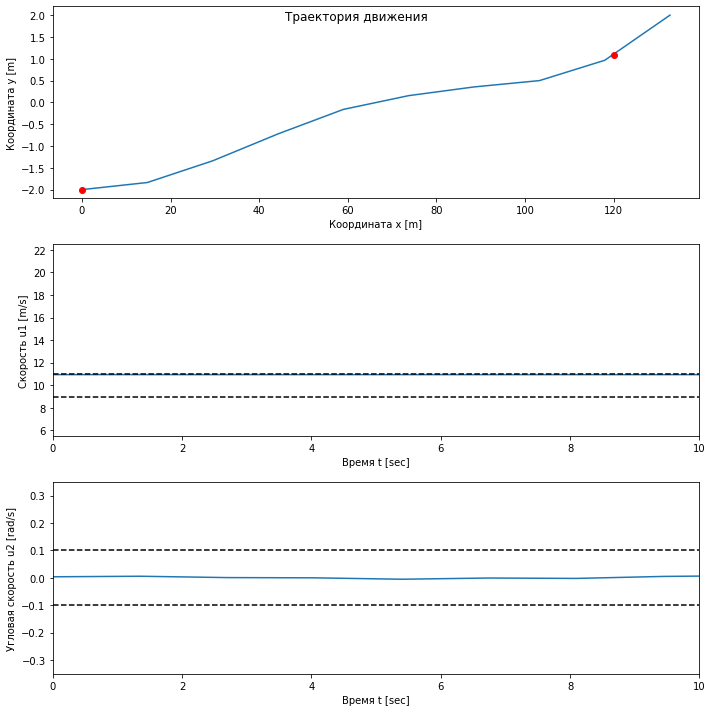

In [11]:
# -*- coding: utf-8 -*-

# optimal_bench.py - benchmarks for optimal control package
# RMM, 27 Feb 2020
#
# This benchmark tests the timing for the optimal control module
# (control.optimal) and is intended to be used for helping tune the
# performance of the functions used for optimization-base control.

import math
import control as ct
import control.flatsys as flat
import control.optimal as opt
import logging


#
# Vehicle steering dynamics
#
# The vehicle dynamics are given by a simple bicycle model.  We take the state
# of the system as (x, y, theta) where (x, y) is the position of the vehicle
# in the plane and theta is the angle of the vehicle with respect to
# horizontal.  The vehicle input is given by (v, phi) where v is the forward
# velocity of the vehicle and phi is the angle of the steering wheel.  The
# model includes saturation of the vehicle steering angle.
#
# System state: x, y, theta
# System input: v, phi
# System output: x, y
# System parameters: wheelbase, maxsteer
#
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    # Saturate the steering input (use min/max instead of clip for speed)
    phi = max(-phimax, min(u[1], phimax))
    # Return the derivative of the state
    return np.array([
        math.cos(x[2]) * u[0],            # xdot = cos(theta) v
        math.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * math.tan(phi)        # thdot = v/l tan(phi)
    ])


def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

# Initial and final conditions
x0 = [0., -2., 0.]; u0 = [10., 0.] #начальное положение автомобиля
xf = [120., 1.1, 0.]; uf = [10., 0.] #конечное положение автомобиля
Tf = 12.14 # увеличение значения приводит к изменению траектории (см.первый график)
# траектория укорачивается при уменьшении значения Tf

# Define the time horizon (and spacing) for the optimization
horizon = np.linspace(0, Tf, 10, endpoint=True)
# Provide an intial guess (will be extended to entire horizon)
bend_left = [10.9405, 0.01]          # slight left veer

# Set up the cost functions
Q = np.diag([5, 10, 1])     # keep lateral error low
R = np.diag([.1, 1])          # minimize applied inputs
quad_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
#        
res = opt.solve_ocp(
        vehicle, horizon, x0, quad_cost,
        initial_guess=bend_left, print_summary=False,
        # solve_ivp_kwargs={'atol': 1e-2, 'rtol': 1e-2},
        minimize_method='trust-constr',
        minimize_options={'finite_diff_rel_step': 0.01},
    )
# функция u зависящая от угол поворота и скорость
# выходные параметры: время, координата y
u = res.inputs
t, y = ct.input_output_response(vehicle, horizon, u, x0) 
#y = res.states
#t = res.time

print('Время t:\n', t)
print('Функция g(х,y):\n', y)
print('Функция u(скорость, угол):\n', u)

plt.figure(figsize=(10, 10)) # увеличение размера графиков

# Plot the results
plt.subplot(3, 1, 1)
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.xlabel("Координата x [m]")
plt.ylabel("Координата y [m]")

plt.subplot(3, 1, 2)
plt.plot(t, u[0])
plt.axis([0, 10, 5.5, 22.5])
plt.plot([0, 10], [9, 9], 'k--', [0, 10], [11, 11], 'k--') # установка диапазона значений
plt.xlabel("Время t [sec]")
plt.ylabel("Скорость u1 [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[1])
plt.axis([0, 10, -0.35, 0.35])
plt.plot([0, 10], [-0.1, -0.1], 'k--', [0, 10], [0.1, 0.1], 'k--') # установка диапазона значений
plt.xlabel("Время t [sec]")
plt.ylabel("Угловая скорость u2 [rad/s]")

plt.suptitle("Траектория движения") #Lane change manuever
plt.tight_layout()
plt.show()

# КОД из ноутбука VIS_1
@author: Vadim

In [ ]:
!pip install box2d-py

#изменение исходного кода ноутбука VIS_1
установка дополнительных библиотек, позволяющих корректно установить OPENAI GYM в Google Colab

полная документация по настройке библиотеки OpenAI GYM:
http://gym.openai.com/docs/

ПС:
- рекомендация с сайта - https://stackoverflow.com/questions/49203023/openai-gym-nameerror-in-google-colaboratory

В результате настроить OPENAI GYM не получилось; **возвращается ошибка:**

NameError                                 Traceback (most recent call last)
<ipython-input-6-36f0eabe77de> in <module>()
      3 print(gym.__version__)# for me: 0.15.4
      4 env = gym.make('CarRacing-v0')
----> 5 env.reset()
      6 for _ in range(1000):
      7     env.render()

NameError: name 'base' is not defined

- еще вариант настройки, который опробован
https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym

In [ ]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

#import
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=0,  # remember to use visible=0 and not False
                                    size=(1400, 900))
_ = _display.start()

#check
!echo $DISPLAY

In [1]:
import gym

print(gym.__version__)# for me: 0.15.4
env = gym.make('CarRacing-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())

0.17.3
Track generation: 1080..1354 -> 274-tiles track


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


NoSuchDisplayException: ignored

# Модель (настройка TensorFlow)

In [24]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# x - данные с информацией о (x, y), у - целевая переменная (u) 
# x - вход в модель; y - выход модели

# y[0], y[1] - x и y
# u[0], u[1] - скорость и угловая скорость(ориентация автомобиля)
# t - время t

x = np.array(u)
y = np.array(t)

In [25]:
print(y)

[ 0.          1.34888889  2.69777778  4.04666667  5.39555556  6.74444444
  8.09333333  9.44222222 10.79111111 12.14      ]


In [95]:
print(x)

[[ 1.09413755e+01  1.09419106e+01  1.09414488e+01  1.09413525e+01
   1.09409246e+01  1.09407626e+01  1.09405797e+01  1.09405225e+01
   1.09404652e+01  1.09404855e+01]
 [ 3.80443368e-03  5.81805311e-03  8.76031705e-04  1.54404102e-05
  -5.11460662e-03 -6.98676601e-04 -2.13240617e-03  5.14152267e-03
   7.99905895e-03  9.82704335e-03]]


In [104]:
#строим и обучаем модель
#используем Activation = relu - получается выше точность
# об Activation - https://faroit.com/keras-docs/1.2.0/activations/ 
# * при количестве слоев: 20 и 20 и 1 и 100 - 0,1424-0,1426
# при количестве слоев: 50 и 20 - 0,1416-0,1420
# при количестве слоев: 20 и 50 - 0,1416-0,1420
# при количестве слоев: 50 и 50 и 3 - 0,1415-0,1420
# при количестве слоев: 20 и 20 и 3 - 0,1415-0,1420
# при количестве слоев: 20 и 10 и 3 и 50 - 0,1416-0,1419
# при количестве слоев: 20 и 20 и 10 и 1 и 50 - 0,1423-0,1425

model = keras.Sequential([Dense(units=20, input_shape=(10,), activation='relu'), 
                          Dense(units=20, activation='sigmoid'),
                          Dense(units=30, activation='sigmoid'),
#                          Dense(units=10, activation='sigmoid'),                          
                          Dense(units=2, activation='sigmoid')
                         ])
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.1))
log = model.fit(x[0], y, epochs=50, verbose=False)
plt.plot(log.history['loss'])
plt.grid(True)
plt.show()

ValueError: ignored

In [105]:
d=model.predict(x)

In [106]:
print(d)

[[0.60006803 0.33666056]
 [0.58648705 0.33601886]]
